# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [ ]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [ ]:
#############
# TO DO 
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# END TO DO 
#############

**2) Check the shape of images and targets.**

In [ ]:
#############
# TO DO 
print(f'With a training set of {X_train.shape[0]} samples, the shape of the images is {X_train.shape[1]}x{X_train.shape[2]} with a depth of {X_train.shape[-1]}, corresponding to RGB pixels')
print(f'With a training set of {y_train.shape[0]} samples, the shape of the targets is {y_train.shape[1]}, which is a scalar that stands for the class')
# END TO DO 
#############

With a training set of 50000 samples, the shape of the images is 32x32 with a depth of 3, corresponding to RGB pixels
With a training set of 50000 samples, the shape of the targets is 1, which is a scalar that stands for the class


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [ ]:
#############
# TO DO 
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# END TO DO 
#############

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [ ]:
#############
# TO DO 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# END TO DO 
#############

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [ ]:
#############
# TO DO 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# END TO DO 
#############

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

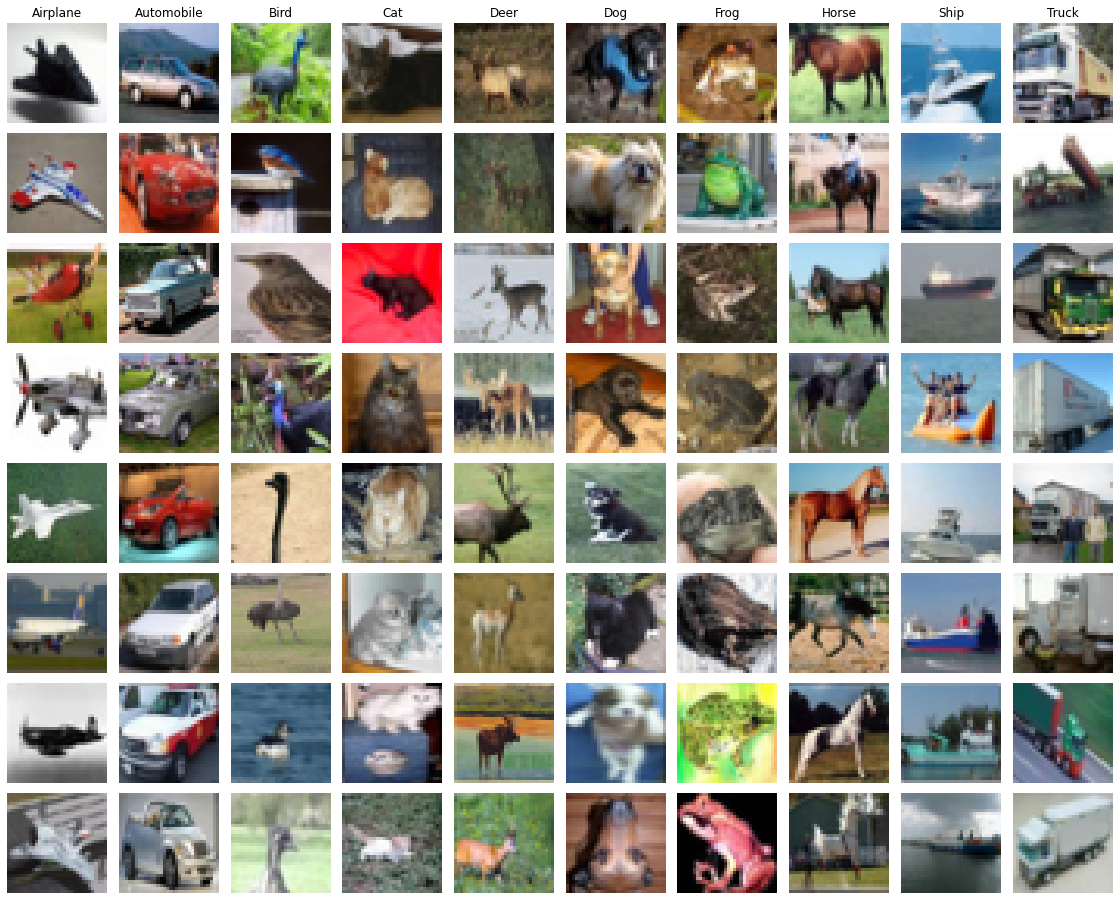

In [ ]:
#############
# TO DO 
fig, ax = plt.subplots(8, 10, figsize = (20, 16))
n_train = len(X_train)
y_labels = np.argmax(y_train, axis=1)
for j in range(10):
    ax[0, j].set_title(labels[j])
    i = 0
    k = 0
    while (k < n_train and i < 8):
            if y_labels[k] == j:
                ax[i, j].imshow(X_train[k])
                ax[i, j].axis('off')
                i += 1
            k += 1
plt.subplots_adjust(wspace = 0.01, hspace = 0.1)
# END TO DO 
#############

The following code summarizes the previous operations. 

With a training set of 50000 samples, the shape of the images is 32x32 with a depth of 3, corresponding to RGB pixels
With a training set of 50000 samples, the shape of the targets is 1, which is a scalar that stands for the class


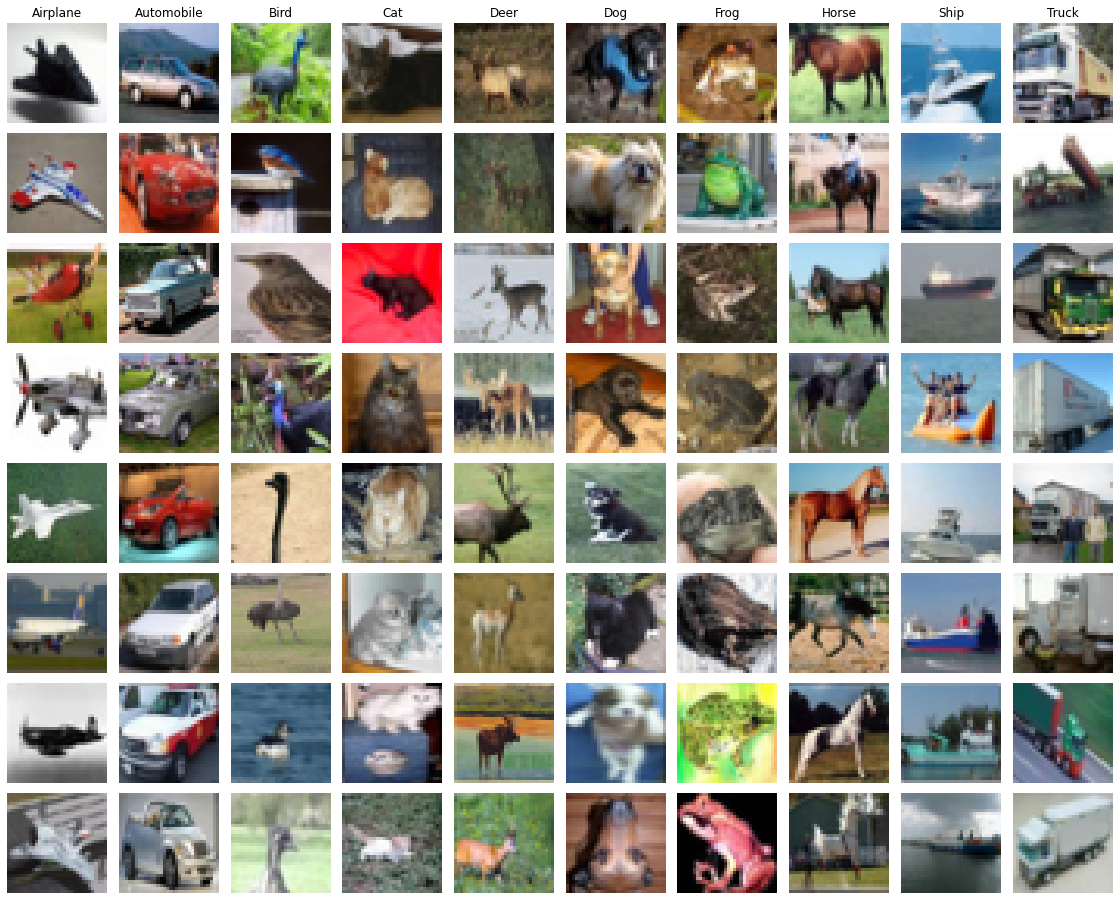

In [ ]:
#############
# TO DO

# Downloading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Checking the shape of images and targets
print(f'With a training set of {X_train.shape[0]} samples, the shape of the images is {X_train.shape[1]}x{X_train.shape[2]} with a depth of {X_train.shape[-1]}, corresponding to RGB pixels')
print(f'With a training set of {y_train.shape[0]} samples, the shape of the targets is {y_train.shape[1]}, which is a scalar that stands for the class')

# Creating a list of labels corresponding to the 10 categories
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Normalizing images from [0,255] to be [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Converting the target arrays to one-hot encodings
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Recreating the figure at the top
fig, ax = plt.subplots(8, 10, figsize = (20, 16))
n_train = len(X_train)
y_labels = np.argmax(y_train, axis=1)
for j in range(10):
    ax[0, j].set_title(labels[j])
    i = 0
    k = 0
    while (k < n_train and i < 8):
            if y_labels[k] == j:
                ax[i, j].imshow(X_train[k])
                ax[i, j].axis('off')
                i += 1
            k += 1
plt.subplots_adjust(wspace = 0.01, hspace = 0.1)

# END TO DO 
#############

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [ ]:
######################
# TO DO
num_classes = 10
model = Sequential([Flatten(input_shape=X_train.shape[1:]),
                    Dense(2048, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(num_classes, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])        
# END TO DO 
######################

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

This model has 4 dense hidden layers of 2048, 1024, 512, and 256 nodes each. The resulting architecture has trainable parameters. 
* From the Flatten layer to the 1st dense hidden layer there are 3072 * 2048 = 6,291,456 connections and therefore weights, with 2048 biases, which gives a total of 6,293,504 parameters.
* From the 1st dense hidden layer to the 2nd dense hidden layer there are 2048 * 1024 = 2,097,152 connections and therefore weights, with 1024 biases, which gives a total of 2,098,176 parameters.
* From the 2nd dense hidden layer to the 3rd dense hidden layer there are 1024 * 512 = 524,288 connections and therefore weights, with 512 biases, which gives a total of 524,800 parameters.
* From the 3rd dense hidden layer to the 4th dense hidden layer there are 512 * 256 = 131,072 connections and therefore weights, with 256 biases, which gives a total of 131,328 parameters.
* From the 4th dense hidden layer to the output layer there are 256 * 10 = 2,560 connections and therefore weights, with 10 biases, which gives a total of 2,570 parameters.

This gives a total of 6,293,504 + 2,098,176 + 524,800 + 131,328 + 2,570 = 9,050,378 trainable parameters.

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [ ]:
######################
# TO DO
model.summary()
# END TO DO 
######################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
______________________________________________

The real number of trainable parameters corresponds to the number we computed.

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [ ]:
######################
# TO DO
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# END TO DO 
######################

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9684 - accuracy: 0.2899 - val_loss: 1.6684 - val_accuracy: 0.4146
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6651 - accuracy: 0.4058 - val_loss: 1.7345 - val_accuracy: 0.3686
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5627 - accuracy: 0.4441 - val_loss: 1.7096 - val_accuracy: 0.4032
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4910 - accuracy: 0.4703 - val_loss: 1.4950 - val_accuracy: 0.4713
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4257 - accuracy: 0.4927 - val_loss: 1.4623 - val_accuracy: 0.4795
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3881 - accuracy: 0.5098 - val_loss: 1.4960 - val_accuracy: 0.4792
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3388 - accuracy: 0.5259 - val_loss: 1.4125 - val_accuracy:

If the model's perfomance is to be evaluated with validation accuracy, the model has a final performance of 52% which is not bad, but extremely suboptimal.

**11) Plot several images with their predictions. Any comment?**

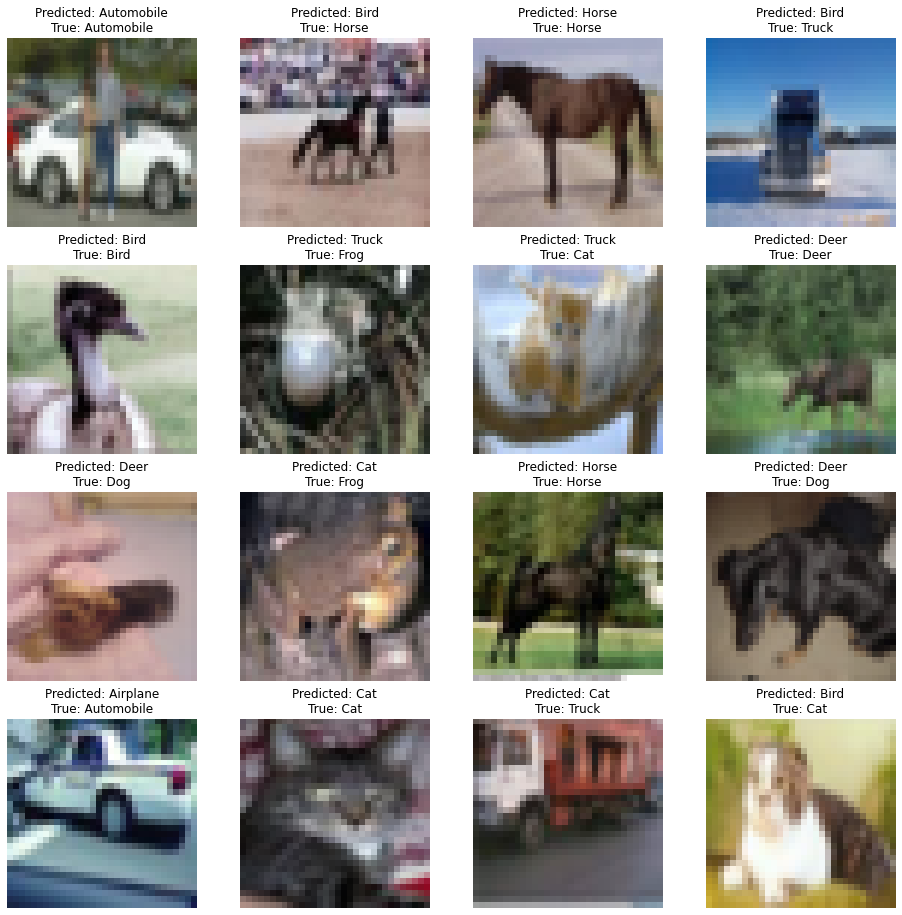

In [ ]:
##################
# TO DO 
fig, ax = plt.subplots(4, 4, figsize = (16, 16))

n_test = len(X_test)
y_labels = np.argmax(y_test, axis=1)
predictions = np.argmax(model.predict(X_test), axis=1)

for i in range(4):
    for j in range(4):
        index = np.random.randint(0, n_test)
        ax[i, j].imshow(X_test[index])
        ax[i, j].set_title("Predicted: {}\nTrue: {}".format(labels[predictions[index]], labels[y_labels[index]]))
        ax[i, j].axis('off')
# END TO DO 
##################

With 6/16 true predictions, it seems that the accuracy observed in these images corresponds pretty well to the one achieved after training. The results seem coherent.

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [ ]:
######################
# TO DO
model_cnn_1 = Sequential([Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
                        Activation('relu'),
                        Conv2D(32, (3, 3), padding='same'),
                        Activation('relu'),
                        MaxPooling2D(pool_size=(2, 2)),
                        Conv2D(64, (3, 3), padding='same'),
                        Activation('relu'),
                        Conv2D(64, (3, 3), padding='same'),
                        Activation('relu'),
                        MaxPooling2D(pool_size=(2, 2)),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dense(num_classes, activation='softmax')])
model_cnn_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# END TO DO 
######################

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

This model has 4 convolutional layers and 2 dense hidden layers. The resulting architecture has trainable parameters.

For the convolutional layers, let's denote i the number of input channels (=3 for RGB images), f the filter size, and o the number of filters. The number of trainable parameters for such a layer is given by i × (f×f) × o + o.
* For the first convolutional layer: i=3, f=3, o=32, therefore the number of trainable parameters is 3 × (3×3) × 32 + 32 = 896.
* For the second convolutional layer: i=32, f=3, o=32, therefore the number of trainable parameters is 32 × (3×3) × 32 + 32 = 9,248.
* For the third convolutional layer: i=32, f=3, o=64, therefore the number of trainable parameters is 32 × (3×3) × 64 + 64 = 18,496.
* For the fourth convolutional layer: i=64, f=3, o=64, therefore the number of trainable parameters is 64 × (3×3) × 64 + 64 = 36,928.
* From the 4th convolutional layer to the 1st dense hidden layer there are 4096 * 512 = 2,097,152 connections and therefore weights, with 512 biases, which gives a total of 2,097,664 parameters. (The 4096 = 64 * 64 is due to the Flatten layer)
* From the 1st dense hidden layer to the output layer there are 512 * 10 = 5,120 connections and therefore weights, with 10 biases, which gives a total of 5,130 parameters.

This gives a total of 896 + 9,248 + 18,496 + 36,928 + 2,097,664 + 5,130 = 2,168,362 trainable parameters.

There are less trainable parameters than in the more simple dense network because there are less connections between layers and therefore less weights to train.

In [ ]:
######################
# TO DO
model_cnn_1.summary()
# END TO DO 
######################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)       

The computations by hand are confirmed well.

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [ ]:
######################
# TO DO
history = model_cnn_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# END TO DO 
######################

Epoch 1/10
1563/1563 [==============================] - 10s 5ms/step - loss: 2.0800 - accuracy: 0.2361 - val_loss: 1.7194 - val_accuracy: 0.3861
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5892 - accuracy: 0.4353 - val_loss: 1.4508 - val_accuracy: 0.4811
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3511 - accuracy: 0.5190 - val_loss: 1.3238 - val_accuracy: 0.5205
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2220 - accuracy: 0.5692 - val_loss: 1.1940 - val_accuracy: 0.5718
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1002 - accuracy: 0.6090 - val_loss: 1.1286 - val_accuracy: 0.6030
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9840 - accuracy: 0.6550 - val_loss: 1.0853 - val_accuracy: 0.6244
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8860 - accuracy: 0.6901 - val_loss: 1.0670 - val_accuracy

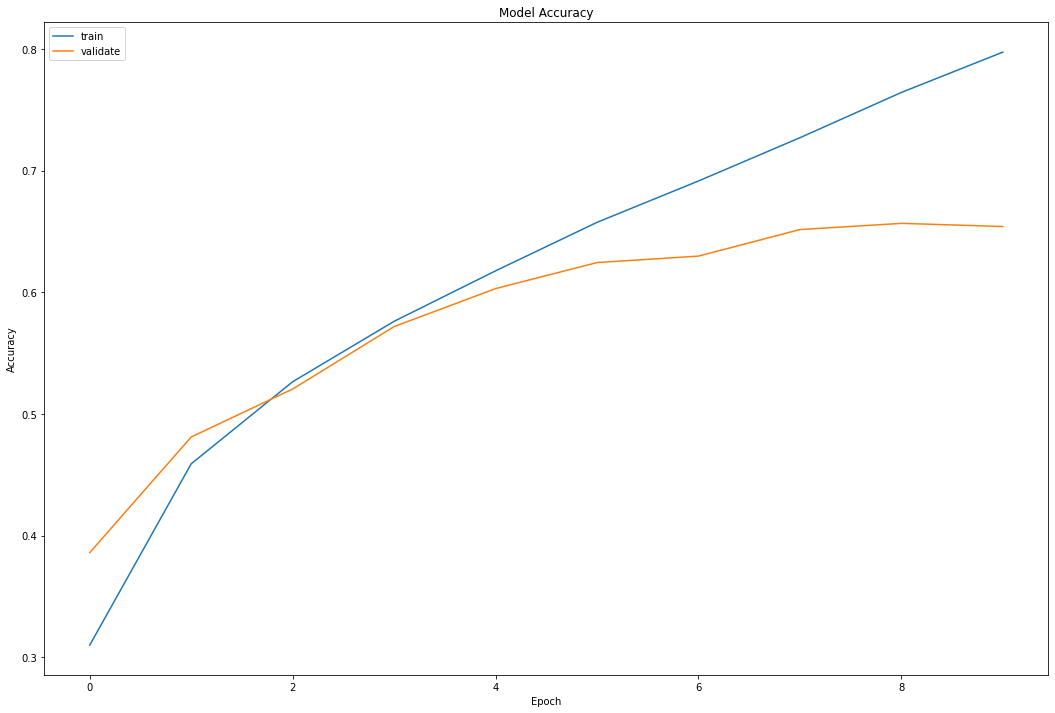

In [ ]:
######################
# TO DO
plt.figure(figsize=(18, 12))
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# END TO DO 
######################

The validation accuracy increases with each epoch at first but starts decreasing at some point.

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [ ]:
######################
# TO DO
batch_sizes = [8, 32, 64, 256]
val_accuracy = []
for batch_size in tqdm_notebook(batch_sizes):
    hist = model_cnn_1.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))
    val_accuracy.append([batch_size, hist.history['val_accuracy'][9]])
# END TO DO
######################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Epoch 1/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.7945 - accuracy: 0.7217 - val_loss: 0.9775 - val_accuracy: 0.6640
Epoch 2/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.5742 - accuracy: 0.7993 - val_loss: 0.9781 - val_accuracy: 0.6829
Epoch 3/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.4022 - accuracy: 0.8596 - val_loss: 1.0957 - val_accuracy: 0.6835
Epoch 4/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.2697 - accuracy: 0.9051 - val_loss: 1.2539 - val_accuracy: 0.6833
Epoch 5/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.1915 - accuracy: 0.9338 - val_loss: 1.4198 - val_accuracy: 0.6859
Epoch 6/10
6250/6250 [==============================] - 20s 3ms/step - loss: 0.1447 - accuracy: 0.9506 - val_loss: 1.4901 - val_accuracy: 0.6877
Epoch 7/10
6250/6250 [==============================] - 21s 3ms/step - loss: 0.1136 - accuracy: 0.9616 - val_loss: 1.6867 - val_ac

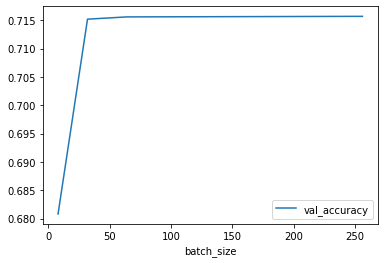

In [ ]:
######################
# TO DO
performance = pd.DataFrame(val_accuracy, columns=['batch_size','val_accuracy'])
performance.plot(x='batch_size', y='val_accuracy')
# END TO DO 
######################

We notice that a larger batch size allows computational speedups (from the parallelism of GPUs). However, using a larger batch size leads to a significant degradation in the quality of the model, as measured by its ability to generalize. This lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function. It seems like the optimal batch size is 64.

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

The validation accuracy begins to decrease at some point, while the training accuracy continues to increase. This phenomenon is called overfitting and is a common problem. Overfitting happens when a model begins to focus on the noise in the training data set and extracts features based on it. This helps the model to improve its performance on the training set but hurts its ability to generalize, therefore the accuracy on the validation set decreases.

In [ ]:
######################
# TO DO
model_cnn_2 = Sequential([Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
                          Activation('relu'),
                          Conv2D(32, (3, 3), padding='same'),
                          Activation('relu'),
                          Dropout(0.25),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          Dropout(0.25),
                          MaxPooling2D(pool_size=(2, 2)),
                          Flatten(),
                          Dense(512, activation='relu'),
                          Dropout(0.25),
                          Dense(num_classes, activation='softmax')])
model_cnn_2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# END TO DO 
######################

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 2.0625 - accuracy: 0.2448 - val_loss: 1.6447 - val_accuracy: 0.4394
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5458 - accuracy: 0.4421 - val_loss: 1.5076 - val_accuracy: 0.5062
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3667 - accuracy: 0.5145 - val_loss: 1.3832 - val_accuracy: 0.5359
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2181 - accuracy: 0.5644 - val_loss: 1.2359 - val_accuracy: 0.5868
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1203 - accuracy: 0.5993 - val_loss: 1.3266 - val_accuracy: 0.5530
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0277 - accuracy: 0.6392 - val_loss: 1.1461 - val_accuracy: 0.6068
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9523 - accuracy: 0.6641 - val_loss: 1.0493 - val_accuracy:

We notice that the validation accuracy is slightly higher for this model than it was for the previous one (without the dropout layers). Therefore, we can conclude that it improves the model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 2.1007 - accuracy: 0.2317 - val_loss: 1.9164 - val_accuracy: 0.3103
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5471 - accuracy: 0.4500 - val_loss: 1.4315 - val_accuracy: 0.4838
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3231 - accuracy: 0.5293 - val_loss: 1.2317 - val_accuracy: 0.5614
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1694 - accuracy: 0.5845 - val_loss: 1.1439 - val_accuracy: 0.6008
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0426 - accuracy: 0.6295 - val_loss: 1.0157 - val_accuracy: 0.6524
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9309 - accuracy: 0.6743 - val_loss: 1.0055 - val_accuracy: 0.6526
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8340 - accuracy: 0.7083 - val_loss: 0.9241 - val_accuracy:

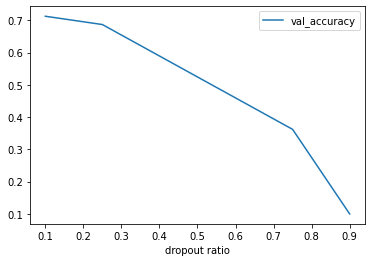

In [ ]:
######################
# TO DO
ratios = [0.1, 0.25, 0.75, 0.9]
val_accuracy = []
for ratio in tqdm_notebook(ratios):
    mod = Sequential([Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
                          Activation('relu'),
                          Conv2D(32, (3, 3), padding='same'),
                          Activation('relu'),
                          Dropout(ratio),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          Dropout(ratio),
                          MaxPooling2D(pool_size=(2, 2)),
                          Flatten(),
                          Dense(512, activation='relu'),
                          Dropout(ratio),
                          Dense(num_classes, activation='softmax')])
    mod.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    hist = mod.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    val_accuracy.append([ratio, hist.history['val_accuracy'][9]])
performance = pd.DataFrame(val_accuracy, columns=['dropout ratio','val_accuracy'])
performance.plot(x='dropout ratio', y='val_accuracy')
# END TO DO 
######################

Dropout offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks. However, a too high dropout ratio means a too high number of neutralized neurons and leads to a decrease of the model's performance.

As a side note, right before the last layer could be a bad place to apply dropout, because the network has no ability to "correct" errors induced by dropout before the classification happens.

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [ ]:
######################
# TO DO
model_cnn_3 = Sequential([Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
                          Activation('relu'),
                          Conv2D(32, (3, 3), padding='same'),
                          Activation('relu'),
                          BatchNormalization(),
                          Dropout(0.25),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          Conv2D(64, (3, 3), padding='same'),
                          Activation('relu'),
                          BatchNormalization(),
                          Dropout(0.25),
                          MaxPooling2D(pool_size=(2, 2)),
                          Flatten(),
                          Dense(512, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.25),
                          Dense(num_classes, activation='softmax')])
model_cnn_3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn_3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# END TO DO 
######################

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9021 - accuracy: 0.3690 - val_loss: 1.6932 - val_accuracy: 0.4625
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2018 - accuracy: 0.5800 - val_loss: 1.3991 - val_accuracy: 0.5327
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9926 - accuracy: 0.6542 - val_loss: 1.0785 - val_accuracy: 0.6228
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8803 - accuracy: 0.6934 - val_loss: 1.2874 - val_accuracy: 0.5739
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7898 - accuracy: 0.7198 - val_loss: 1.1978 - val_accuracy: 0.6030
Epoch 6/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7382 - accuracy: 0.7434 - val_loss: 0.9130 - val_accuracy: 0.6901
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6737 - accuracy: 0.7659 - val_loss: 1.0395 - val_accuracy:

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. 
We notice that the validation accuracy is almost the same for this model than for the previous one (without batch normalization). Therefore, we can conclude that, in our case, it does not have much impact on the model's performance.

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

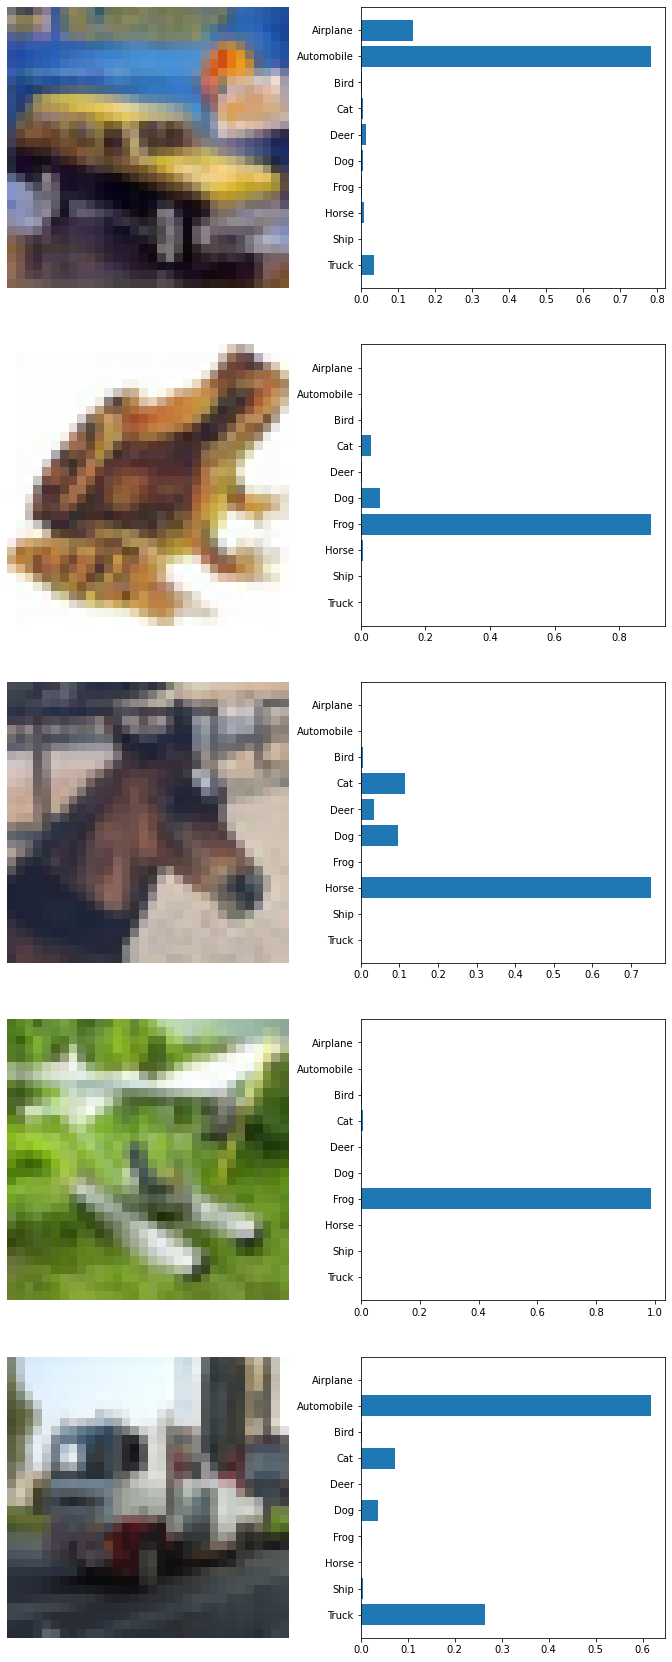

In [ ]:
######################
# TO DO
fig, ax = plt.subplots(5, 2, figsize = (12, 30))

n_test = len(X_test)
y = np.arange(len(labels))
predictions = model_cnn_3.predict(X_test)

for i in range(5):
    index = np.random.randint(0, n_test)
    ax[i, 0].imshow(X_test[index])
    ax[i, 0].axis('off')
    ax[i, 1].barh(y, predictions[index])
    ax[i, 1].set_yticks(y)
    ax[i, 1].set_yticklabels(labels)
    ax[i, 1].invert_yaxis()
    
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_model_cnn.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_cnn_3.save(model_path)
# END TO DO 
######################

These plots show the probabilities that each image has of corresponding to a certain label. The label with the highest probability ends up being the one chosen by the model to classify the image.

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

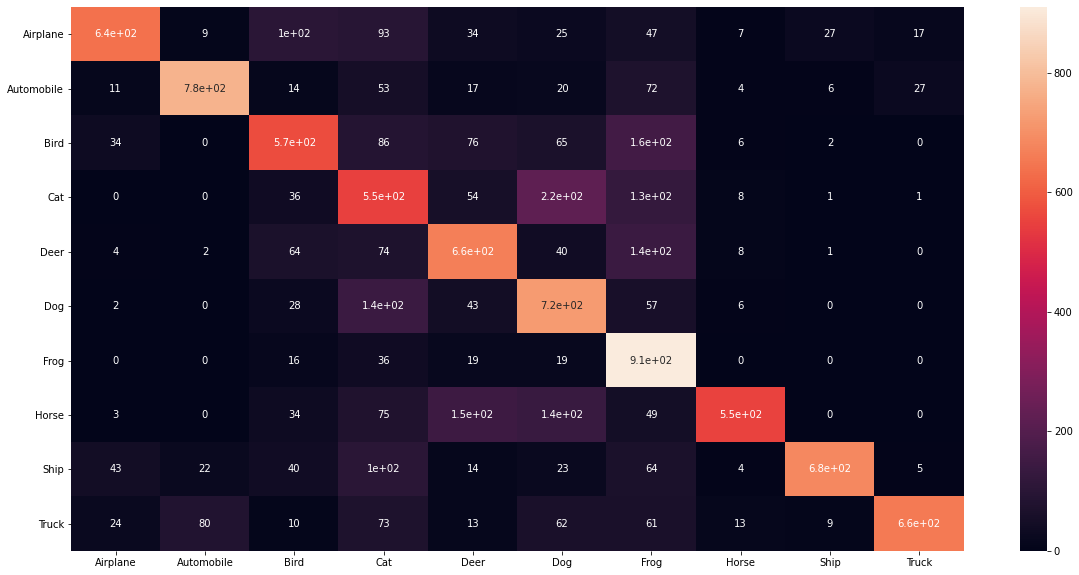

In [ ]:
######################
# TO DO
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_cnn_3.predict(X_test), axis=1)
cm = metrics.confusion_matrix(y_true, y_pred)
df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(20, 10))
sns.heatmap(df, annot=True)
plt.show()
# END TO DO 
######################

We notice that cats and horses are the most misclassified as there are only 550 images of cats and horses that were labeled well. As for the relationships between classes, we notice that dogs and cats are the most confounded, which is understandable as the two animals look alike and have similar features.

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [ ]:
###########################
# TO DO 

# Loading VGG16 which was pre-trained on the ImageNet dataset
pretrained_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 
pretrained_conv_base.summary()

# END TO DO 
##################

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
###########################
# TO DO 

# Building the model
pretrained_model = Sequential([pretrained_conv_base,
                               Flatten(),
                               Dense(2048, activation='relu'),
                               Dense(1024, activation='relu'),
                               Dense(512, activation='relu'),
                               Dense(256, activation='relu'),
                               Dense(num_classes, activation='softmax')])
pretrained_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])    

# END TO DO 
##################

In [29]:
##################
# TO DO 

# Data Augmentation
train_datagen = ImageDataGenerator(shear_range=0.2,
                                   rotation_range=2,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

train_generator = train_datagen.flow(X_train, y_train, batch_size = 32)

# END TO DO 
##################

In [30]:
##################
# TO DO 
pretrained_model.fit(
      train_generator,
      steps_per_epoch=X_train.shape[0]//32,
      epochs=10,
      validation_data=(X_test, y_test),
      validation_steps=50)
# END TO DO 
##################

Epoch 1/10
1562/1562 [==============================] - 45s 29ms/step - loss: 0.3290 - accuracy: 0.8863 - val_loss: 0.5176 - val_accuracy: 0.8326
Epoch 2/10
1562/1562 [==============================] - 45s 29ms/step - loss: 0.2780 - accuracy: 0.9036 - val_loss: 0.6237 - val_accuracy: 0.8148
Epoch 3/10
1562/1562 [==============================] - 46s 30ms/step - loss: 0.2424 - accuracy: 0.9155 - val_loss: 0.4175 - val_accuracy: 0.8676
Epoch 4/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.2098 - accuracy: 0.9275 - val_loss: 0.4644 - val_accuracy: 0.8573
Epoch 5/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.1812 - accuracy: 0.9384 - val_loss: 0.4345 - val_accuracy: 0.8686
Epoch 6/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.1633 - accuracy: 0.9442 - val_loss: 0.4463 - val_accuracy: 0.8635
Epoch 7/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.1493 - accuracy: 0.9481 - val_loss: 0.4409 -

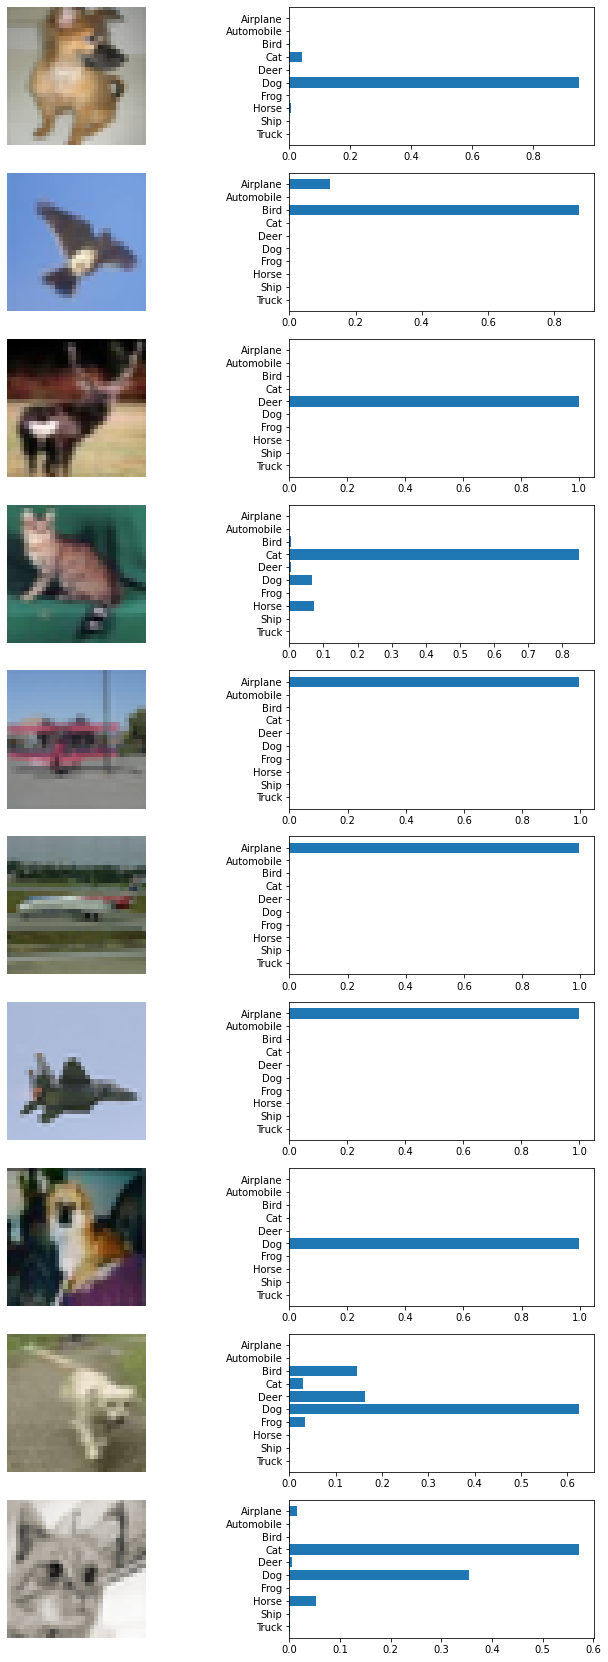

In [31]:
######################
# TO DO
fig, ax = plt.subplots(10, 2, figsize = (12, 30))

n_test = len(X_test)
y = np.arange(len(labels))
predictions = pretrained_model.predict(X_test)

for i in range(10):
    index = np.random.randint(0, n_test)
    ax[i, 0].imshow(X_test[index])
    ax[i, 0].axis('off')
    ax[i, 1].barh(y, predictions[index])
    ax[i, 1].set_yticks(y)
    ax[i, 1].set_yticklabels(labels)
    ax[i, 1].invert_yaxis()
# END TO DO 
######################

We notice that this new classifier is quite effective, it yields more accurate results with 87% accuracy on the test set compared to all previous CNN models. 
Using a sample of 10 images to verify the predictions, we notice that the classifier is accurate, which confirms that using a pre-trained model can help boost performance.   
